<a href="https://colab.research.google.com/github/muffin-head/netflixReccommendationEngine/blob/main/netflixReccommendationEngine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning':0})
import seaborn as sns
sns.set_style('whitegrid')
import os
from scipy import sparse
from scipy.sparse import csr_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
import random

In [2]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable

DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 23.3 will enforce this behaviour change. A possible replacement is to use pip for package installation..

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



  Obtaining dependency information for scikit-learn from https://files.pythonhosted.org/packages/a8/e9/3e4879974a7c4dcaca2a746dde3df08d0ae8f14c74b03591616ce5f0a8b1/scikit_learn-1.4.0-1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for joblib>=1.2.0 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for threadpoolctl>=2.0.0 from https://files.pythonhosted.org/packages/81/12/fd4dea011af9d69e1cad05c75f3f7202cdcbeac9b712eea58ca779a72865/threadpoolctl-3.2.0-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/10.6 MB ? eta -:--:--
   --- ------------------------------------ 0.8/10.6 MB 17.8 MB/s eta 0:00:01
   ------- -------------------------------- 1.9/10.6 MB 20.5 MB/s eta 0:00:01
   ----------- ---------------------------- 3.0/10.6 MB 21.2 MB/s eta 0:00:01
   -------------- ------------------------- 3.9/10.6 

In [4]:
from google.colab import drive
drive.mount('drive')

ModuleNotFoundError: No module named 'google.colab'

In [7]:
start = datetime.now()

# Create a file 'data.csv' before reading it
# Read all the files in netflix and store them in one big file('data.csv')
# We re reading from each of the four files and appendig each rating to a global file 'train.csv'
data = open('data.csv', mode='w')

row = list()
files=["C:/study/Case Study 9/archive/combined_data_1.txt","C:/study/Case Study 9/archive/combined_data_2.txt","C:/study/Case Study 9/archive/combined_data_3.txt","C:/study/Case Study 9/archive/combined_data_4.txt"]

for file in files:
    print("Reading ratings from {}...".format(file))
    with open(file) as f:
        for line in f:
            line = line.strip()
            if line.endswith(':'):
                # All below are ratings for this movie, until another movie appears.
                movie_id = line.replace(':', '')
            else:
                row = [x for x in line.split(',')]
                row.insert(0, movie_id)
                data.write(','.join(row))
                data.write('\n')
    print("Done.\n")
data.close()
print('Time taken :', datetime.now() - start)

Reading ratings from C:/study/Case Study 9/archive/combined_data_1.txt...
Done.

Reading ratings from C:/study/Case Study 9/archive/combined_data_2.txt...
Done.

Reading ratings from C:/study/Case Study 9/archive/combined_data_3.txt...
Done.

Reading ratings from C:/study/Case Study 9/archive/combined_data_4.txt...
Done.

Time taken : 0:05:56.922574


In [89]:
dataframe=pd.read_csv('data.csv',sep=',',names=['movie','user','rating','date'])



In [90]:
dataframe.date=pd.to_datetime(dataframe.date)
dataframe.sort_values(by='date', inplace=True)


In [94]:
print(sum(dataframe.isnull().any()))
print(dataframe.duplicated(['movie','user','rating','date']))
total_movie=np.unique(dataframe['movie'])
total_user=np.unique(dataframe['user'])
np.unique(dataframe['date'])
print(dataframe.shape[0])

0
56431994    False
9056171     False
58698779    False
48101611    False
81893208    False
            ...  
49939086    False
42072268    False
47098649    False
55621336    False
25464092    False
Length: 100480507, dtype: bool
100480507


In [11]:

if not os.path.isfile('train.csv'):
  dataframe.iloc[:int(dataframe.shape[0]*0.80)].to_csv('train.csv',index=False)
if not os.path.isfile('test.csv'):
  dataframe.iloc[int(dataframe.shape[0]* 0.80):].to_csv('test.csv',index=False)

In [3]:
train_df=pd.read_csv('train.csv',parse_dates=['date'])
test_df=pd.read_csv('test.csv')

In [4]:
train_df.head()

,movie,user,rating,date
0,10341,510180,4,1999-11-11
1,1798,510180,5,1999-11-11
2,10774,510180,3,1999-11-11
3,8651,510180,2,1999-11-11
4,14660,510180,2,1999-11-11


In [5]:
train_df.shape

(80384405, 4)

# Find out how often rating are given by a user

In [6]:
# method to make y-axis more readable
def human(num, units = 'M'):
    units = units.lower()
    num = float(num)
    if units == 'k':
        return str(num/10**3) + " K"
    elif units == 'm':
        return str(num/10**6) + " M"
    elif units == 'b':
        return str(num/10**9) +  " B"

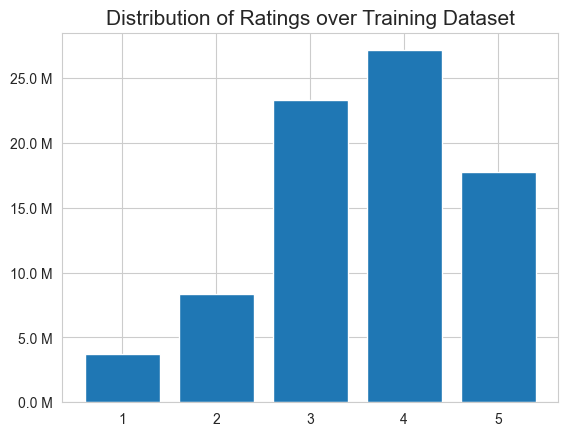

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
%matplotlib inline

# Assuming train_df is your DataFrame and it has a column 'rating'

# Calculate rating counts manually
rating_counts = train_df['rating'].value_counts().sort_index()
fig, ax = plt.subplots()
plt.title('Distribution of Ratings over Training Dataset', fontsize=15)
ax.bar(rating_counts.index, rating_counts.values)
y_ticks = ax.get_yticks()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: human(x, 'M')))
ax.set_xticks(range(1, 6))
ax.set_xticklabels([str(i) for i in range(1, 6)])

plt.show()


C:\Users\c23005186\AppData\Local\Temp\ipykernel_17108\3302483081.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
C:\Users\c23005186\AppData\Local\Temp\ipykernel_17108\3302483081.py:12: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)


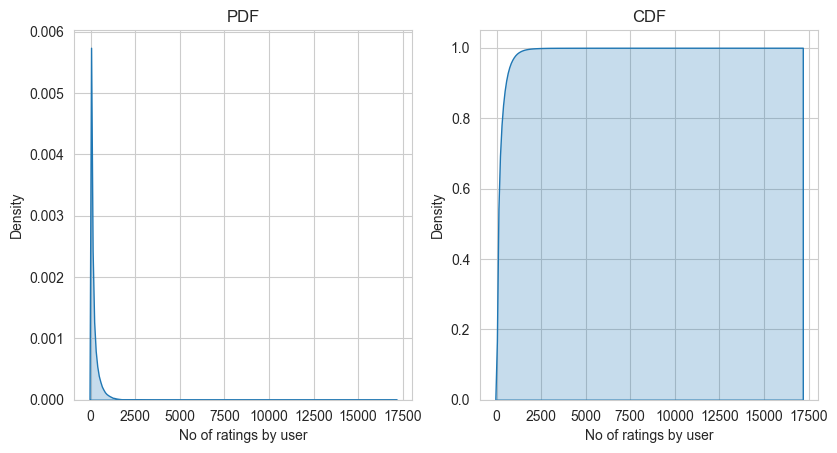

In [11]:
no_of_rated_movies_per_user = train_df.groupby(by='user')['rating'].count().sort_values(ascending=False)

no_of_rated_movies_per_user.head()
fig = plt.figure(figsize=plt.figaspect(.5))

ax1 = plt.subplot(121)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, ax=ax1)
plt.xlabel('No of ratings by user')
plt.title("PDF")

ax2 = plt.subplot(122)
sns.kdeplot(no_of_rated_movies_per_user, shade=True, cumulative=True,ax=ax2)
plt.xlabel('No of ratings by user')
plt.title('CDF')

plt.show()

In [20]:
quantiles = no_of_rated_movies_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')
quantiles[::5]

0.00        1
0.05        7
0.10       15
0.15       21
0.20       27
0.25       34
0.30       41
0.35       50
0.40       60
0.45       73
0.50       89
0.55      109
0.60      133
0.65      163
0.70      199
0.75      245
0.80      307
0.85      392
0.90      520
0.95      749
1.00    17112
Name: rating, dtype: int64

In [21]:
print('\n No of ratings at last 5 percentile : {}\n'.format(sum(no_of_rated_movies_per_user>= 749)) )


 No of ratings at last 5 percentile : 20305



In [27]:
if os.path.isfile('train_sparse_mat.npz'):
    train_sparse_mat=sparse.load_npz('train_sparse_mat.npz')
else:
    train_sparse_mat=sparse.csr_matrix((train_df.rating.values,(train_df.user.values,train_df.movie.values)),)
    sparse.save_npz('train_sparse_mat,npz',train_sparse_mat)

In [28]:
if os.path.isfile('test_sparse_mat.npz'):
    test_sparse_mat=sparse.load_npz('test_sparse_mat.npz')
else:
    test_sparse_mat=sparse.csr_matrix((test_df.rating.values,(test_df.user.values,test_df.movie.values)),)
    sparse.save_npz('test_sparse_mat,npz',test_sparse_mat)

In [29]:
train_sparse_mat.shape

(2649430, 17771)

In [30]:
train_df.shape

(80384405, 4)

## Global average

In [31]:
train_avg=dict()
train_global_avg=train_sparse_mat.sum()/train_sparse_mat.count_nonzero()
train_avg['global_avg']=train_global_avg

In [32]:
train_avg

{'global_avg': 3.582890686321557}

## local average function for user

In [80]:
sum_of_rating=train_sparse_mat.sum(axis=1).A1
is_rated=train_sparse_mat!=0
no_of_rating=is_rated.sum(axis=1).A1
u,_ = train_sparse_mat.shape
user_rating_avg=dict()
for i in range(u):
    if no_of_rating[i]!=0:
        avg=sum_of_rating[i]/no_of_rating[i]
        user_rating_avg[i]=avg
train_avg['user'] =  user_rating_avg

In [36]:
sum_of_rating.shape[0]

2649430

In [74]:
no_of_rating[168]

24

In [78]:
user_rating_avg[10]

3.3781094527363185

In [81]:
sum_of_rating=train_sparse_mat.sum(axis=0).A1
is_rated=train_sparse_mat!=0
no_of_rating=is_rated.sum(axis=0).A1
_,m = train_sparse_mat.shape
movie_rating_avg=dict()
for i in range(m):
    if no_of_rating[i]!=0:
        avg=sum_of_rating[i]/no_of_rating[i]
        movie_rating_avg[i]=avg
train_avg['movie'] =   movie_rating_avg

In [79]:
movie_rating_avg[4]

2.763358778625954

C:\Users\c23005186\AppData\Local\Temp\ipykernel_17108\1851094589.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_averages, ax=a, hist=False,
C:\Users\c23005186\AppData\Local\Temp\ipykernel_17108\1851094589.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(user_avera

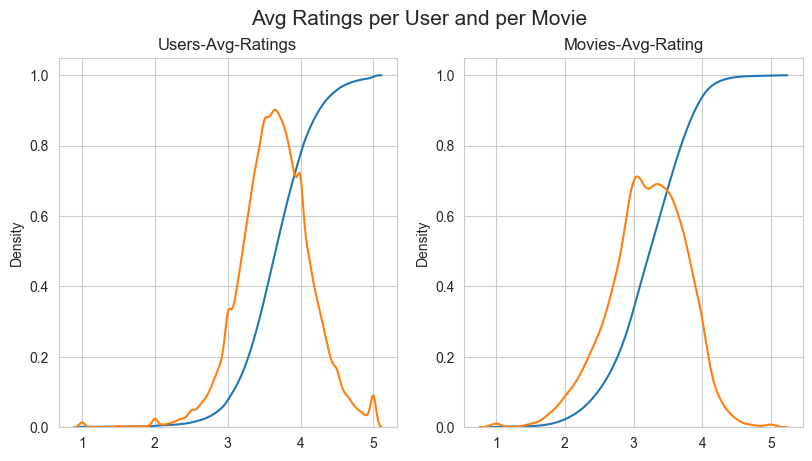

0:00:15.799674


In [88]:
start = datetime.now()
# draw pdfs for average rating per user and average
fig, (a, b) = plt.subplots(nrows=1, ncols=2, figsize=plt.figaspect(.5))
fig.suptitle('Avg Ratings per User and per Movie', fontsize=15)

a.set_title('Users-Avg-Ratings')
user_averages = [i for i in train_avg['user'].values()]
sns.distplot(user_averages, ax=a, hist=False,
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(user_averages, ax=a, hist=False,label='Pdf')

b.set_title('Movies-Avg-Rating')
# get the list of movie_average_ratings from the dictionary..
movie_averages = [i for i in train_avg['movie'].values()]
sns.distplot(movie_averages, ax=b, hist=False,
             kde_kws=dict(cumulative=True), label='Cdf')
sns.distplot(movie_averages, ax=b, hist=False, label='Pdf')

plt.show()
print(datetime.now() - start)

## lets check about cold start problem

In [98]:
user_not_in_train=len(total_user)-len(train_avg['user'])
print(user_not_in_train)

75148


In [102]:
movie_not_in_train=len(total_movie)-len(train_avg['movie'])
print(movie_not_in_train)

346


In [105]:
start = datetime.now()
if not os.path.isfile('m_msim_sparse.npz'):
    print("It seems you don't have that file. Computing movie_movie similarity...")
    start = datetime.now()
    m_m_sim_sparse = cosine_similarity(X=train_sparse_mat.T, dense_output=False)
    print("Done..")
    # store this sparse matrix in disk before using it. For future purposes.
    print("Saving it to disk without the need of re-computing it again.. ")
    sparse.save_npz("m_msim_sparse.npz", m_m_sim_sparse)
    print("Done..")
else:
    print("It is there, We will get it.")
    m_m_sim_sparse = sparse.load_npz("m_m_sim_sparse.npz")
    print("Done ...")

print("It's a ",m_m_sim_sparse.shape," dimensional matrix")

print(datetime.now() - start)

It seems you don't have that file. Computing movie_movie similarity...
Done..
Saving it to disk without the need of re-computing it again.. 
Done..
It's a  (17771, 17771)  dimensional matrix
0:08:22.871265


In [ ]:
movie_ids = np.unique(m_m_sim_sparse.nonzero()[1])


In [134]:
movie_titles

,movie_id,year_of_release,title
1,2003.0,Dinosaur Planet,NaN
2,2004.0,Isle of Man TT 2004 Review,NaN
3,1997.0,Character,NaN
4,1994.0,Paula Abdul's Get Up & Dance,NaN
5,2004.0,The Rise and Fall of ECW,NaN
...,...,...,...
17766,2002.0,Where the Wild Things Are and Other Maurice Se...,NaN
17767,2004.0,Fidel Castro: American Experience,NaN
17768,2000.0,Epoch,NaN
17769,2003.0,The Company,NaN


In [148]:

movie_titles = pd.read_csv("C:/study/Case Study 9/archive/movie_titles.csv", sep=',', header = None, names=['movie_id', 'year_of_release', 'title'],usecols=[0, 1, 2],index_col=0, verbose=True, encoding = "ISO-8859-1")

similarities = m_m_sim_sparse[67].toarray().ravel()

similar_indices = similarities.argsort()[::-1][1:]
sim_indices = similarities.argsort()[::-1][1:]
movie_titles.loc[sim_indices[:10]]

Tokenization took: 6.00 ms
Type conversion took: 11.00 ms
Parser memory cleanup took: 0.00 ms


,year_of_release,title
movie_id,,
323,1999.0,Modern Vampires
4044,1998.0,Subspecies 4: Bloodstorm
1688,1993.0,To Sleep With a Vampire
13962,2001.0,Dracula: The Dark Prince
12053,1993.0,Dracula Rising
16279,2002.0,Vampires: Los Muertos
4667,1996.0,Vampirella
1900,1997.0,Club Vampire
13873,2001.0,The Breed


In [164]:
from scipy import sparse
import numpy as np
# Create a small 2D sparse matrix
# For example, using a 3x3 matrix with some nonzero elements
row = np.array([0, 1, 2])
col = np.array([1, 2, 0])
data = np.array([1, 0, 3])

sparse_matrix = sparse.csr_matrix((data, (row, col)), shape=(3, 3))

# Use sparse.find to extract nonzero elements
row_ind, col_ind, ratings = sparse.find(sparse_matrix)

print("Row indices:", row_ind)
print("Column indices:", col_ind)
print("Values:", ratings)


'''
Row 2, Column 0: This has the value 3.
Row 0, Column 1: This has the value 1.'''


Row indices: [2 0]
Column indices: [0 1]
Values: [3 1]


'\nRow 2, Column 0: This has the value 3.\nRow 0, Column 1: This has the value 1.'

In [149]:
def get_sample_sparse_matrix(sparse_matrix, no_users, no_movies, path, verbose = True):
    """
        It will get it from the ''path'' if it is present  or It will create
        and store the sampled sparse matrix in the path specified.
    """

    # get (row, col) and (rating) tuple from sparse_matrix...
    row_ind, col_ind, ratings = sparse.find(sparse_matrix)
    users = np.unique(row_ind)
    movies = np.unique(col_ind)

    print("Original Matrix : (users, movies) -- ({} {})".format(len(users), len(movies)))
    print("Original Matrix : Ratings -- {}\n".format(len(ratings)))

    # It just to make sure to get same sample everytime we run this program..
    # and pick without replacement....
    np.random.seed(15)
    sample_users = np.random.choice(users, no_users, replace=False)
    sample_movies = np.random.choice(movies, no_movies, replace=False)
    # get the boolean mask or these sampled_items in originl row/col_inds..
    mask = np.logical_and( np.isin(row_ind, sample_users),
                      np.isin(col_ind, sample_movies) )

    sample_sparse_matrix = sparse.csr_matrix((ratings[mask], (row_ind[mask], col_ind[mask])),
                                             shape=(max(sample_users)+1, max(sample_movies)+1))

    if verbose:
        print("Sampled Matrix : (users, movies) -- ({} {})".format(len(sample_users), len(sample_movies)))
        print("Sampled Matrix : Ratings --", format(ratings[mask].shape[0]))

    print('Saving it into disk for furthur usage..')
    # save it into disk
    sparse.save_npz(path, sample_sparse_matrix)
    if verbose:
            print('Done..\n')

    return sample_sparse_matrix

In [165]:
start = datetime.now()
path = "C:/study/Case Study 9/archive/sample_train_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_train_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    # get 10k users and 1k movies from available data
    sample_train_sparse_matrix = get_sample_sparse_matrix(train_sparse_mat, no_users=10000, no_movies=1000,
                                             path = path)

print(datetime.now() - start)

Original Matrix : (users, movies) -- (405041 17424)
Original Matrix : Ratings -- 80384405

Sampled Matrix : (users, movies) -- (10000 1000)
Sampled Matrix : Ratings -- 129286
Saving it into disk for furthur usage..
Done..

0:02:52.328197


In [167]:
start = datetime.now()

path = "C:/study/Case Study 9/archive/sample_test_sparse_matrix.npz"
if os.path.isfile(path):
    print("It is present in your pwd, getting it from disk....")
    # just get it from the disk instead of computing it
    sample_test_sparse_matrix = sparse.load_npz(path)
    print("DONE..")
else:
    # get 5k users and 500 movies from available data
    sample_test_sparse_matrix = get_sample_sparse_matrix(test_sparse_mat, no_users=5000, no_movies=500,
                                                 path = "C:/study/Case Study 9/archive/sample_test_sparse_matrix.npz")
print(datetime.now() - start)

Original Matrix : (users, movies) -- (349312 17757)
Original Matrix : Ratings -- 20096102

Sampled Matrix : (users, movies) -- (5000 500)
Sampled Matrix : Ratings -- 7333
Saving it into disk for furthur usage..
Done..

0:00:12.192411


In [168]:
# get the user averages in dictionary (key: user_id/movie_id, value: avg rating)

def get_average_ratings(sparse_matrix, of_users):

    # average ratings of user/axes
    ax = 1 if of_users else 0 # 1 - User axes,0 - Movie axes

    # ".A1" is for converting Column_Matrix to 1-D numpy array
    sum_of_ratings = sparse_matrix.sum(axis=ax).A1
    # Boolean matrix of ratings ( whether a user rated that movie or not)
    is_rated = sparse_matrix!=0
    # no of ratings that each user OR movie..
    no_of_ratings = is_rated.sum(axis=ax).A1

    # max_user  and max_movie ids in sparse matrix
    u,m = sparse_matrix.shape
    # creae a dictonary of users and their average ratigns..
    average_ratings = { i : sum_of_ratings[i]/no_of_ratings[i]
                                 for i in range(u if of_users else m)
                                    if no_of_ratings[i] !=0}

    # return that dictionary of average ratings
    return average_ratings

In [169]:
sample_train_averages = dict()
# get the global average of ratings in our train set.
global_average = sample_train_sparse_matrix.sum()/sample_train_sparse_matrix.count_nonzero()
sample_train_averages['global'] = global_average
sample_train_averages['user'] = get_average_ratings(sample_train_sparse_matrix, of_users=True)
print('\nAverage rating of user 1515220 :',sample_train_averages['user'][1515220])
sample_train_averages['movie'] =  get_average_ratings(sample_train_sparse_matrix, of_users=False)
print('\n AVerage rating of movie 15153 :',sample_train_averages['movie'][15153])
# get users, movies and ratings from our samples train sparse matrix
sample_train_users, sample_train_movies, sample_train_ratings = sparse.find(sample_train_sparse_matrix)


Average rating of user 1515220 : 3.9655172413793105

 AVerage rating of movie 15153 : 2.6458333333333335


In [170]:
############################################################
# It took me almost 10 hours to prepare this train dataset.#
############################################################
start = datetime.now()
if os.path.isfile('C:/study/Case Study 9/archive/reg_train.csv'):
    print("File already exists you don't have to prepare again..." )
else:
    print('preparing {} tuples for the dataset..\n'.format(len(sample_train_ratings)))
    with open('C:/study/Case Study 9/archive/reg_train.csv', mode='w') as reg_data_file:
        count = 0
        for (user, movie, rating)  in zip(sample_train_users, sample_train_movies, sample_train_ratings):
            st = datetime.now()
        #     print(user, movie)
            #--------------------- Ratings of "movie" by similar users of "user" ---------------------
            # compute the similar Users of the "user"
            user_sim = cosine_similarity(sample_train_sparse_matrix[user], sample_train_sparse_matrix).ravel()
            top_sim_users = user_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar users for this movie
            top_ratings = sample_train_sparse_matrix[top_sim_users, movie].toarray().ravel()
            # we will make it's length "5" by adding movie averages to .
            top_sim_users_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_users_ratings.extend([sample_train_averages['movie'][movie]]*(5 - len(top_sim_users_ratings)))
        #     print(top_sim_users_ratings, end=" ")


            #--------------------- Ratings by "user"  to similar movies of "movie" ---------------------
            # compute the similar movies of the "movie"
            movie_sim = cosine_similarity(sample_train_sparse_matrix[:,movie].T, sample_train_sparse_matrix.T).ravel()
            top_sim_movies = movie_sim.argsort()[::-1][1:] # we are ignoring 'The User' from its similar users.
            # get the ratings of most similar movie rated by this user..
            top_ratings = sample_train_sparse_matrix[user, top_sim_movies].toarray().ravel()
            # we will make it's length "5" by adding user averages to.
            top_sim_movies_ratings = list(top_ratings[top_ratings != 0][:5])
            top_sim_movies_ratings.extend([sample_train_averages['user'][user]]*(5-len(top_sim_movies_ratings)))
        #     print(top_sim_movies_ratings, end=" : -- ")

            #-----------------prepare the row to be stores in a file-----------------#
            row = list()
            row.append(user)
            row.append(movie)
            # Now add the other features to this data...
            row.append(sample_train_averages['global']) # first feature
            # next 5 features are similar_users "movie" ratings
            row.extend(top_sim_users_ratings)
            # next 5 features are "user" ratings for similar_movies
            row.extend(top_sim_movies_ratings)
            # Avg_user rating
            row.append(sample_train_averages['user'][user])
            # Avg_movie rating
            row.append(sample_train_averages['movie'][movie])

            # finalley, The actual Rating of this user-movie pair...
            row.append(rating)
            count = count + 1

            # add rows to the file opened..
            reg_data_file.write(','.join(map(str, row)))
            reg_data_file.write('\n')
            if (count)%10000 == 0:
                # print(','.join(map(str, row)))
                print("Done for {} rows----- {}".format(count, datetime.now() - start))


print(datetime.now() - start)

preparing 129286 tuples for the dataset..

Done for 10000 rows----- 0:41:07.910742
Done for 20000 rows----- 1:21:57.950525
Done for 30000 rows----- 2:02:39.758706
Done for 40000 rows----- 2:43:22.449734
Done for 50000 rows----- 3:23:56.462285
Done for 60000 rows----- 4:04:54.363148
Done for 70000 rows----- 4:46:16.970674
Done for 80000 rows----- 5:26:43.447698
Done for 90000 rows----- 6:07:30.662086
Done for 100000 rows----- 6:48:25.970403
Done for 110000 rows----- 7:29:38.328864
Done for 120000 rows----- 8:10:20.920124
8:48:27.431089
